# Analisis de grupos.

Compara las variables con respecto a la variable predictora para mirar ganancia de información, chi cuadrado y prueba T, según la variable.

In [1]:
R.Version()$version.string

[1] "R version 3.3.1 (2016-06-21)"

In [2]:
library(ggplot2)
# library(MLmetrics)
# library(FactoMineR)
library(party) #install.packages("") 
library(rpart) # install.packages("ggplot2", repos='https://cloud.r-project.org')

Warning message:
: package 'ggplot2' was built under R version 3.3.2Warning message:
: package 'party' was built under R version 3.3.2Loading required package: grid
Loading required package: mvtnorm
Warning message:
: package 'mvtnorm' was built under R version 3.3.2Loading required package: modeltools
Warning message:
: package 'modeltools' was built under R version 3.3.2Loading required package: stats4

Attaching package: 'modeltools'

The following object is masked _by_ '.GlobalEnv':

    dimension

Loading required package: strucchange
Warning message:
: package 'strucchange' was built under R version 3.3.2Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: sandwich
Warning message:
: package 'sandwich' was built under R version 3.3.2Warning message:
: package 'rpart' was built under R version 3.3.2

In [3]:
entropy_y= function(y_values){
    frecs=prop.table(table(y_values))
    p_val=frecs["SI"]+1e-16# este decimal pequeño es para corregir el error logaritmo cero, da NAN y no deja avanzar
    q_val=frecs["NO"]+1e-16# este decimal pequeño es para corregir el error logaritmo cero, da NAN y no deja avanzar
    return (as.numeric(-(q_val*log2(q_val))-(p_val*log2(p_val))))}

entropy_xy=function(true_condition,reactivo){ #La formula actualizada para calcular más de dos valores
    df_dat=data.frame("true_condition"=true_condition,"reactivo"=reactivo)
    df_dat=df_dat[rowSums(!is.na(df_dat))==2,]
    entr_xy=0
    for (val in unique(df_dat$reactivo)){
        entr_y=entropy_y(df_dat[df_dat$reactivo==val,"true_condition"])
        p_val=sum(df_dat$reactivo==val)/length(df_dat$reactivo)
        entr_xy=(entr_y*p_val)+entr_xy
    }
    return (entr_xy)
}    
info_gain=function(true_condition,reactivo){entropy_y(true_condition)-entropy_xy(true_condition,reactivo)}

In [4]:
cuestionario_1=read.csv(file="SOLO IVIC.csv", header = F, encoding="UTF-8", row.names=1)
print(paste("Archivo de datos cargado ", nrow(cuestionario_1)," filas y ",ncol(cuestionario_1),"columnas"))
variables_1=read.csv("vars.csv", header=T)
print(paste("Archivo variables cargado ", nrow(variables_1)," filas y ",ncol(variables_1),"columnas"))
colnames(cuestionario_1)=variables_1$ident
#row.names(cuestionario_1)=cuestionario_1$INTERNO
variables_1$procesar=as.logical(variables_1$procesar)

cuestionario_1$var_35=as.Date(as.character.factor(cuestionario_1$var_35),format = "%m/%d/%Y")

[1] "Archivo de datos cargado  27944  filas y  314 columnas"
[1] "Archivo variables cargado  314  filas y  4 columnas"


In [5]:
## Separar variables a procesar, de las que no.
cuestionario_2=cuestionario_1[,variables_1$procesar]

variables_2=variables_1[variables_1$procesar,1:3]
 # variables_2$tipo[5]="CATEGORICA" # la variable reincidenciareco es la variable dependiente
##

for (i in 1:ncol(cuestionario_2)){
    if(variables_2$tipo[i]=="CATEGORICA"){
#         cuestionario_2[is.na(cuestionario_2[,i]),i]=9999
        cuestionario_2[,i]=factor(cuestionario_2[,i])
    }else{
        cuestionario_2[,i]=as.numeric(cuestionario_2[,i])
    }
}
cuestionario_2$var_5=factor(cuestionario_1$var_5, labels=c("NO","SI"))
cuestionario_3=cuestionario_2[!colnames(cuestionario_2)=="var_5"]
cuestionario_3=data.frame("REINCIDENCIARECO"=cuestionario_2$var_5,cuestionario_3)
print(paste("Variables a procesar separadas y transformados sus valores. Forma final del cuestionario:", list(dim(cuestionario_3))))

str(cuestionario_3)

[1] "Variables a procesar separadas y transformados sus valores. Forma final del cuestionario: c(27944, 168)"
'data.frame':	27944 obs. of  168 variables:
 $ REINCIDENCIARECO: Factor w/ 2 levels "NO","SI": 2 2 1 2 1 1 1 1 1 1 ...
 $ var_6           : Factor w/ 2 levels "1","2": 1 1 1 1 1 1 1 1 1 1 ...
 $ var_7           : num  NA 3 NA 2 NA NA 3 NA 2 2 ...
 $ var_8           : Factor w/ 8 levels "0","1","2","3",..: 2 1 6 6 2 2 6 1 1 6 ...
 $ var_9           : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ var_10          : num  0 3 4 4 4 3 4 4 3 3 ...
 $ var_11          : num  1 0 1 0 0 0 0 0 0 0 ...
 $ var_12          : num  24 37 47 48 31 37 40 45 28 32 ...
 $ var_13          : num  2 1 3 1 1 1 5 1 1 1 ...
 $ var_14          : Factor w/ 2 levels "0","1": 1 1 2 1 1 1 2 1 1 1 ...
 $ var_15          : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ var_16          : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ var_17          : Factor w/ 2 levels "0","1": 1 1 1 1 

In [6]:
# cuestionario_3b=cuestionario_3
# # table(rowSums(is.na(cuestionario_3))==0)
# table(cuestionario_3$REINCIDENCIARECO)
# summary(cuestionario_3$REINCIDENCIARECO)
dim(cuestionario_1)

tbl=table(
cuestionario_3$var_8==7
);print(tbl)
prop.table(tbl)


[1] 27944   314


FALSE  TRUE 
27942     2 



       FALSE         TRUE 
9.999284e-01 7.157171e-05 

In [7]:
# cuestionario_3=cuestionario_3b
################
cuestionario_3=cuestionario_3[cuestionario_1$var_35<as.Date("12/31/2012",format = "%m/%d/%Y"),] # eliminar registros posteriores a 2012
cuestionario_3=cuestionario_3[cuestionario_3$var_12>17&
                              cuestionario_3$var_12<66,
                              1:ncol(cuestionario_3)]# rango limitado de edad

cuestionario_3=cuestionario_3[cuestionario_3$var_6==1,
                              1:ncol(cuestionario_3)]#Solo hombres

cuestionario_3=cuestionario_3[,c(1,3:ncol(cuestionario_3))]# Se elimina la variable género

cuestionario_3$var_7[is.na(cuestionario_3$var_7)]=0# Na's Se reemplazan por cero hijos
cuestionario_3=cuestionario_3[cuestionario_3$var_7<13,
                              1:ncol(cuestionario_3)]# Menos de 13 hijos

cuestionario_3=cuestionario_3[!(cuestionario_3$var_8==7),
                              1:ncol(cuestionario_3)]# Eliminar los religiosos

# Unificar estado civil
cuestionario_3$var_8[cuestionario_3$var_8==0]=1 # sin datos se pasó a soltero como valor por defecto
cuestionario_3$var_8[cuestionario_3$var_8==4]=3 # Divorciado se pasó a separado
cuestionario_3$var_8[cuestionario_3$var_8==6]=3 # Viudo se pasó a separado

variables_2=variables_2[c(1,3:nrow(variables_2)),]# se elimina la variable género por quedar solo hombres
###############

# cuestionario_3=cuestionario_3[rowSums(is.na(cuestionario_3))==0,]# Eliminar los casos con datos vacíos
summary(cuestionario_3$REINCIDENCIARECO)

NO    SI 
10781 10286

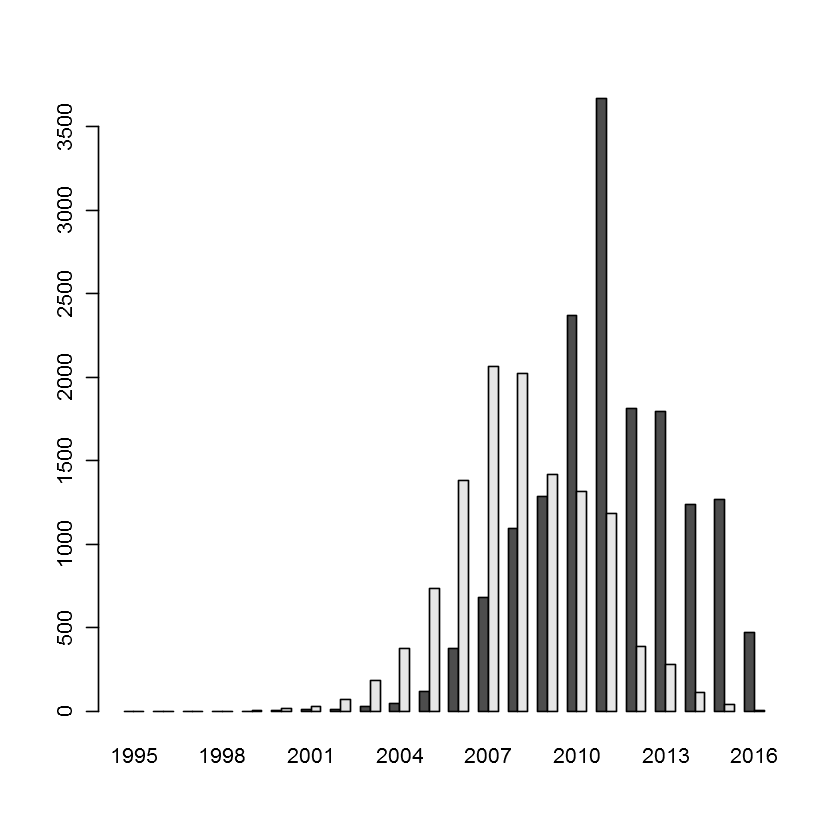

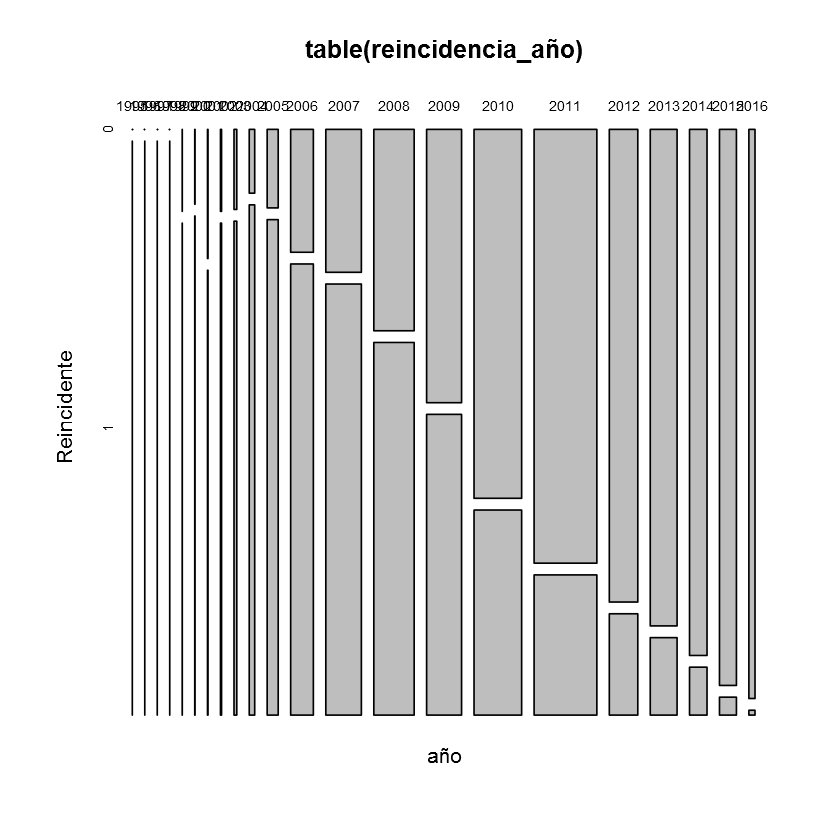

In [8]:
reincidencia_año=data.frame(año=as.numeric(format(as.Date(cuestionario_1$var_35),"%Y")),Reincidente=cuestionario_1$var_5)
barplot(
    t(
        table(reincidencia_año)
    ),beside=T
)
plot(table(reincidencia_año))
# summary(as.numeric(format(as.Date(cuestionario_1$var_35),"%Y")))


In [9]:
tbl_df=data.frame(table(reincidencia_año))
reincid_año=data.frame(rowSums(table(reincidencia_año)))
reincid_año$no_rein= tbl_df[tbl_df$Reincidente==0,]$Freq
reincid_año$si_rein= tbl_df[tbl_df$Reincidente==1,]$Freq
reincid_año$no_rein_cumsum=cumsum(tbl_df[tbl_df$Reincidente==0,]$Freq)
reincid_año$si_rein_cumsum=cumsum(tbl_df[tbl_df$Reincidente==1,]$Freq)
colnames(reincid_año)[1]="n_internos"
reincid_año$n_internos_cumsum=cumsum(reincid_año$n_internos)

reincid_año

,n_internos,no_rein,si_rein,no_rein_cumsum,si_rein_cumsum,n_internos_cumsum
1995,1,0,1,0,1,1
1996,1,0,1,0,2,2
1997,2,0,2,0,4,4
1998,2,0,2,0,6,6
1999,7,1,6,1,12,13
2000,23,3,20,4,32,36
2001,40,9,31,13,63,76
2002,84,12,72,25,135,160
2003,215,30,185,55,320,375
2004,423,47,376,102,696,798


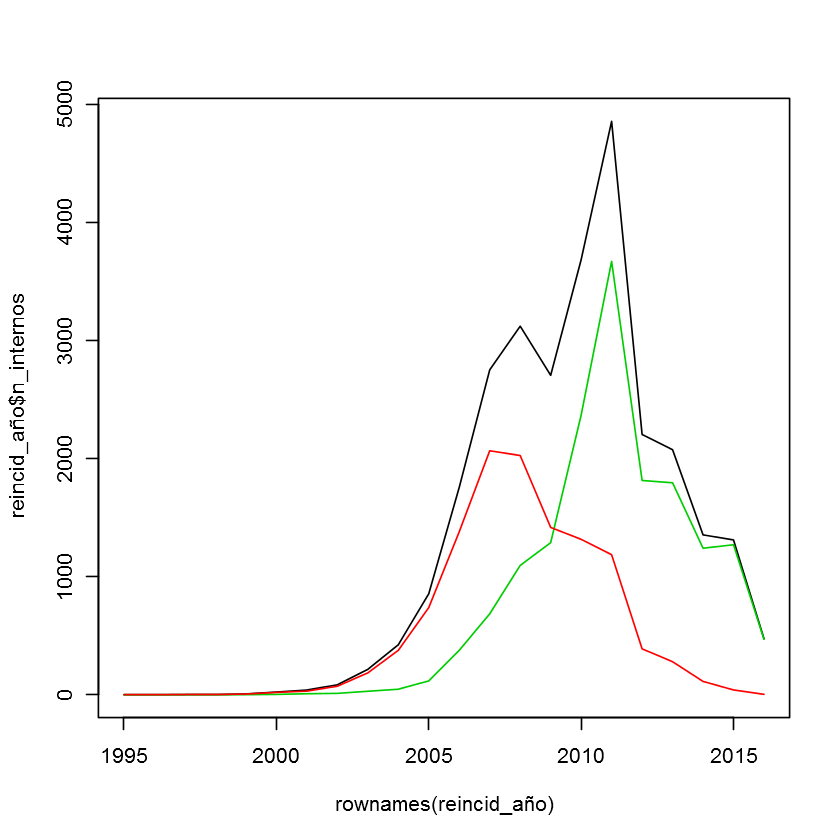

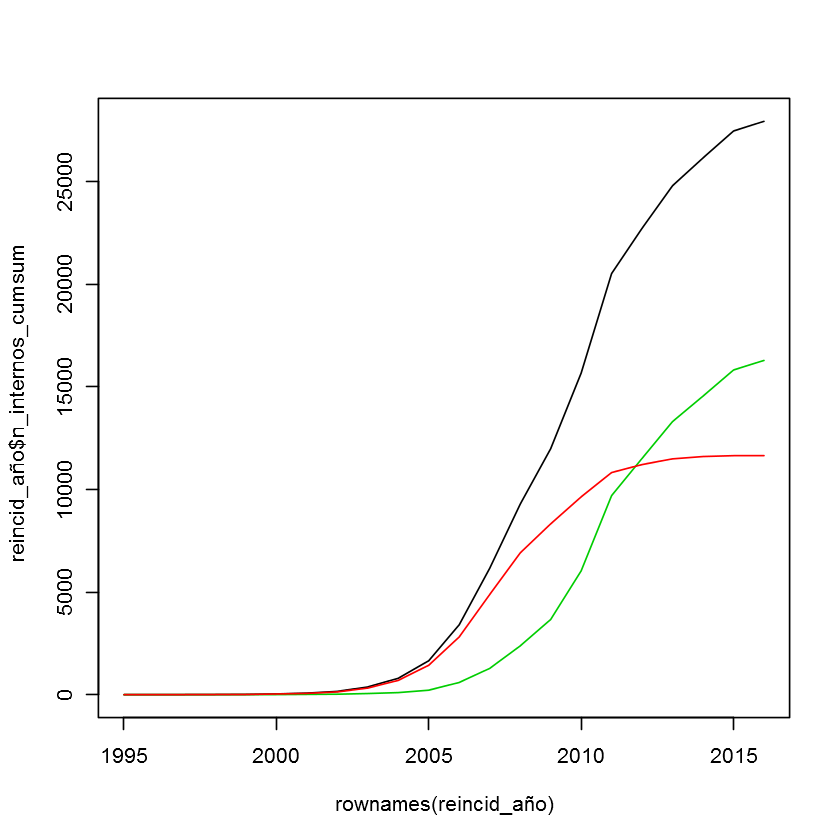

In [10]:
plot(rownames(reincid_año),reincid_año$n_internos, type="l")#, col=1,ylim=c(0,30000))
lines(rownames(reincid_año),reincid_año$no_rein, col=3)
lines(rownames(reincid_año),reincid_año$si_rein, col=2)

plot(rownames(reincid_año),reincid_año$n_internos_cumsum, type="l")#, col=1,ylim=c(0,30000))
lines(rownames(reincid_año),reincid_año$no_rein_cumsum, col=3)
lines(rownames(reincid_año),reincid_año$si_rein_cumsum, col=2)



In [11]:
results=data.frame("ident"=rep(NA,ncol(cuestionario_3)),
                   "nom_var"=rep(NA,ncol(cuestionario_3)),
                   "info_gain"=rep(NA,ncol(cuestionario_3)),
                   "chisq"=rep(NA,ncol(cuestionario_3)),
                   "t_test"=rep(NA,ncol(cuestionario_3)),
                   "decis"=rep(NA,ncol(cuestionario_3))
)
for(i in 2:ncol(cuestionario_3)){
    print (paste("variable***",i))
    ident_var=variables_2[variables_2$ident==colnames(cuestionario_3)[i],"ident"]
    print(paste("Identificador de la variable***",ident_var))
    results$ident[i]=as.character(ident_var)
    nombr_var=variables_2[variables_2$ident==colnames(cuestionario_3)[i],"nombre"]
    print(paste("Nombre variable***",nombr_var))
    results$nom_var[i]=as.character(nombr_var)
    print(colnames(cuestionario_3)[i])
    tipo_var=variables_2[variables_2$ident==colnames(cuestionario_3)[i],"tipo"]
    decis=NULL

    if(tipo_var=="CATEGORICA"){
        print(tipo_var)
        info_gain_var=info_gain(cuestionario_3$REINCIDENCIARECO,cuestionario_3[,i])
        print(paste("info Gain",info_gain_var))
        results$info_gain[i]=info_gain_var
        test_var=chisq.test(table(cuestionario_3$REINCIDENCIARECO,cuestionario_3[,i]))
        valor_p_chi=test_var$p.value
        if (valor_p_chi=="NaN"){valor_p_chi=0.99}
        results$chisq[i]=valor_p_chi
#         fisher_test_var=fisher.test(table(cuestionario_3$REINCIDENCIARECO,cuestionario_3[,i]))
#         fisher_valor_p=round(test_var$p.value,2)
        print(paste("prueba chi",valor_p_chi))
#         print(paste("prueba fisher",fisher_valor_p))
        if (valor_p_chi<0.05){
            decis="Si existen diferencias"
            if(info_gain_var>0.003){results$decis[i]=2}else{results$decis[i]=1}
        }else{
            decis="No existen diferencias"
            results$decis[i]=0
        }
    }else{
        print(tipo_var)
        t_test=t.test(cuestionario_3[,i]~cuestionario_3$REINCIDENCIARECO,var.equal=T)
        valor_p=t_test$p.value
        results$t_test[i]=valor_p
        print(paste("prueba t",valor_p))
        if (valor_p<0.05){
            decis="Si existen diferencias"
            results$decis[i]=1
        }else{
            decis="No existen diferencias"
            results$decis[i]=0
        }
    }
    print (decis)
}


[1] "variable*** 2"
[1] "Identificador de la variable*** var_7"
[1] "Nombre variable*** N_HIJOS"
[1] "var_7"
[1] RAZON
Levels:  CATEGORICA RAZON
[1] "prueba t 0.000631212369557173"
[1] "Si existen diferencias"
[1] "variable*** 3"
[1] "Identificador de la variable*** var_8"
[1] "Nombre variable*** ESTADO_CIVIL"
[1] "var_8"
[1] CATEGORICA
Levels:  CATEGORICA RAZON
[1] "info Gain 0.00433061320430017"


Warning message:
In chisq.test(table(cuestionario_3$REINCIDENCIARECO, cuestionario_3[, : Chi-squared approximation may be incorrect

[1] "prueba chi 0.99"
[1] "No existen diferencias"
[1] "variable*** 4"
[1] "Identificador de la variable*** var_9"
[1] "Nombre variable*** REALIZO_ACTIVIDAD"
[1] "var_9"
[1] CATEGORICA
Levels:  CATEGORICA RAZON
[1] "info Gain 9.85697620081716e-07"
[1] "prueba chi 0.975423538639399"
[1] "No existen diferencias"
[1] "variable*** 5"
[1] "Identificador de la variable*** var_10"
[1] "Nombre variable*** CALIFICACION"
[1] "var_10"
[1] RAZON
Levels:  CATEGORICA RAZON
[1] "prueba t 4.37559731833179e-159"
[1] "Si existen diferencias"
[1] "variable*** 6"
[1] "Identificador de la variable*** var_11"
[1] "Nombre variable*** SANCIONES"
[1] "var_11"
[1] RAZON
Levels:  CATEGORICA RAZON
[1] "prueba t 1.97875995103942e-52"
[1] "Si existen diferencias"
[1] "variable*** 7"
[1] "Identificador de la variable*** var_12"
[1] "Nombre variable*** EDAD_INGRESO"
[1] "var_12"
[1] RAZON
Levels:  CATEGORICA RAZON
[1] "prueba t 5.03478367004115e-147"
[1] "Si existen diferencias"
[1] "variable*** 8"
[1] "Identificador

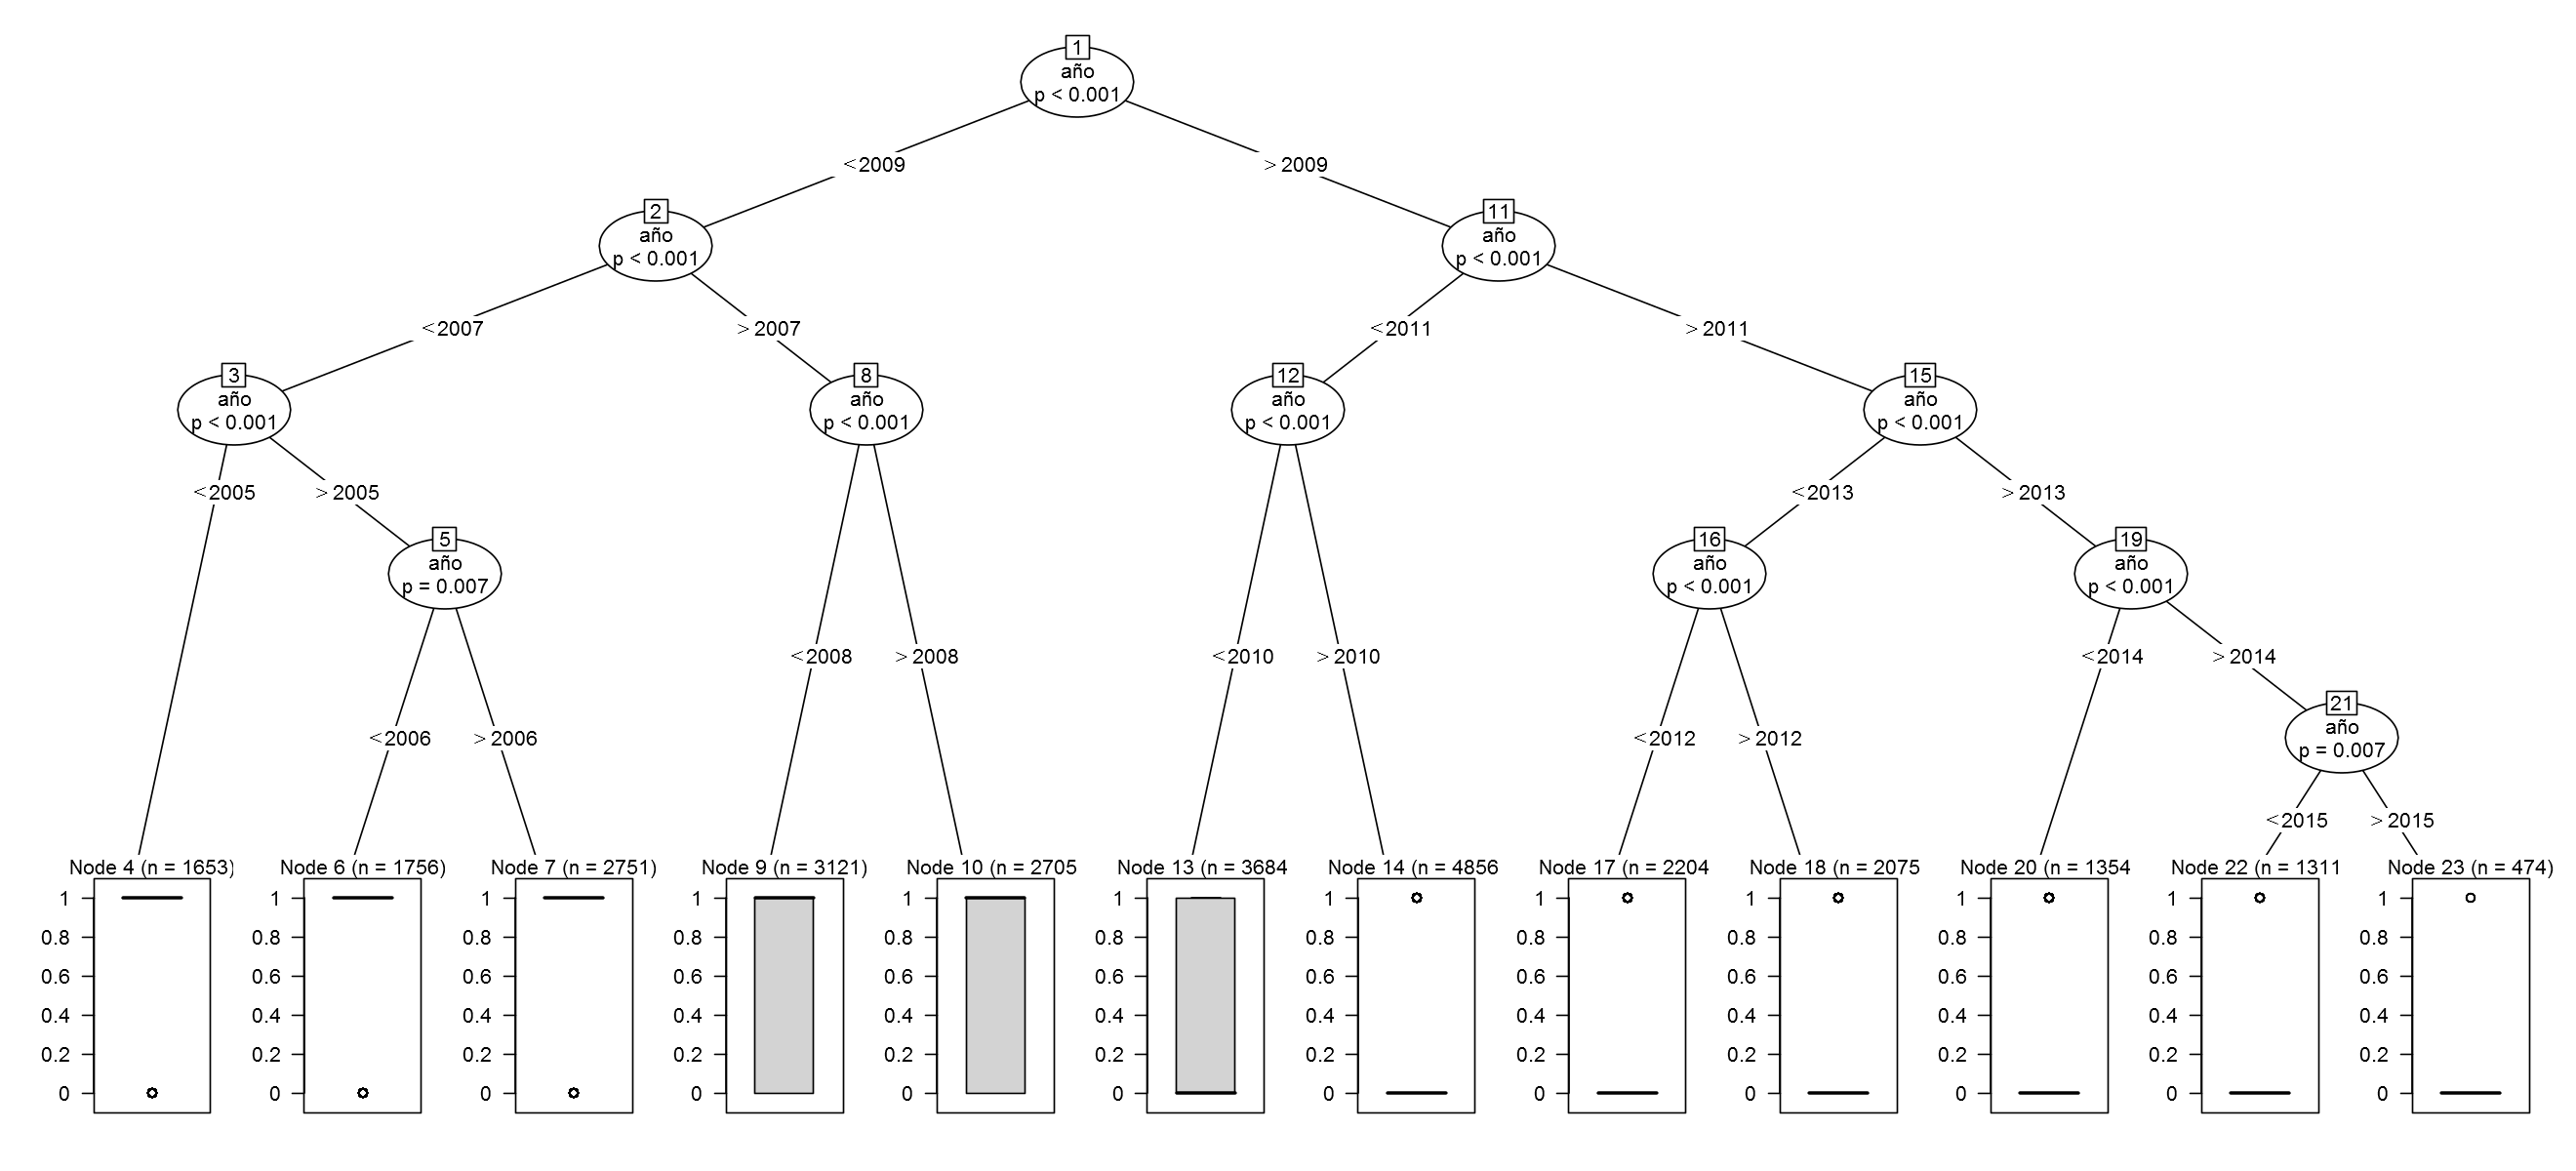

In [12]:
options(repr.plot.width=22, repr.plot.height=10) 
tree_dat=ctree(Reincidente ~ año, data=reincidencia_año)
plot(tree_dat)
# reincidencia_año



In [13]:
cuest_5=cuestionario_3[c("REINCIDENCIARECO","var_10","var_11","var_12","var_13","var_14")]
varnames=c("REINCIDENCIARECO",# REINCIDENCIARECO
           "Calificacion",#var_10 
           "Num_Sanciones",#var_11 
           "Edad_1er_Ingreso",#var_12
           "Num_Delitos",#var_13
           "Homicidio"#var_14
          )
colnames(cuest_5)=varnames

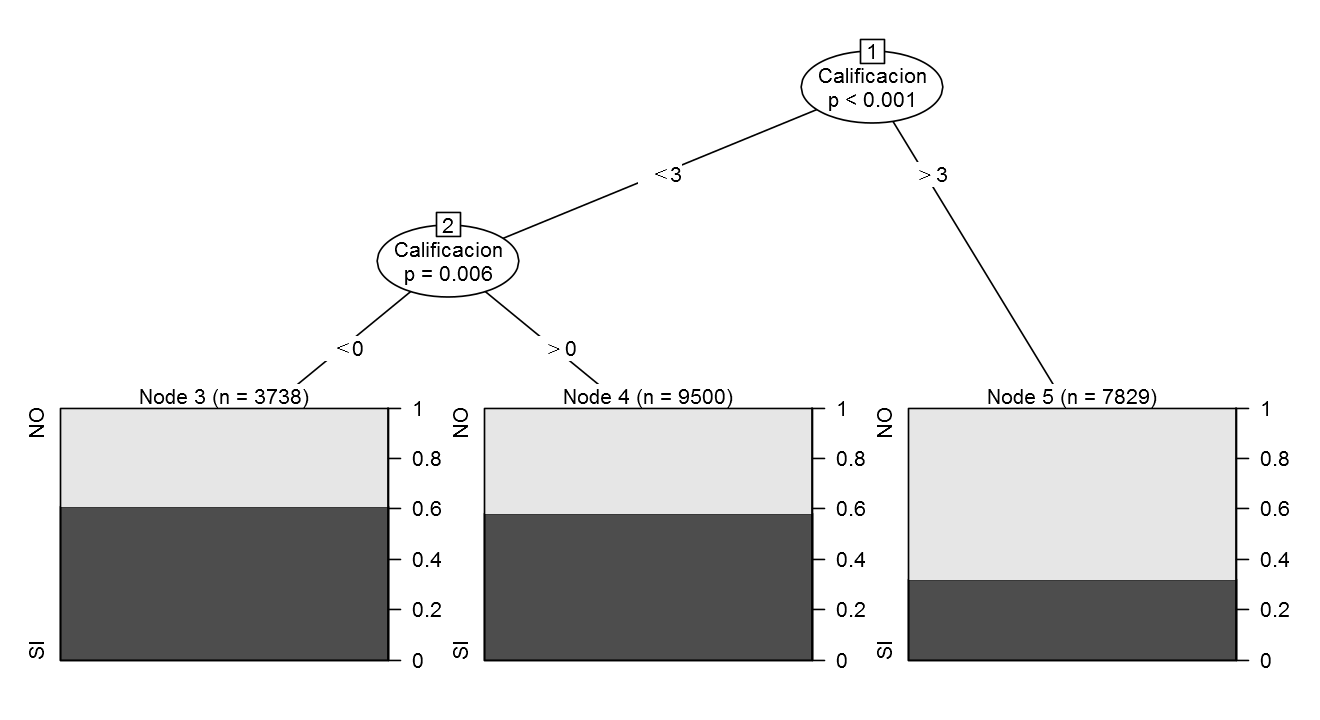

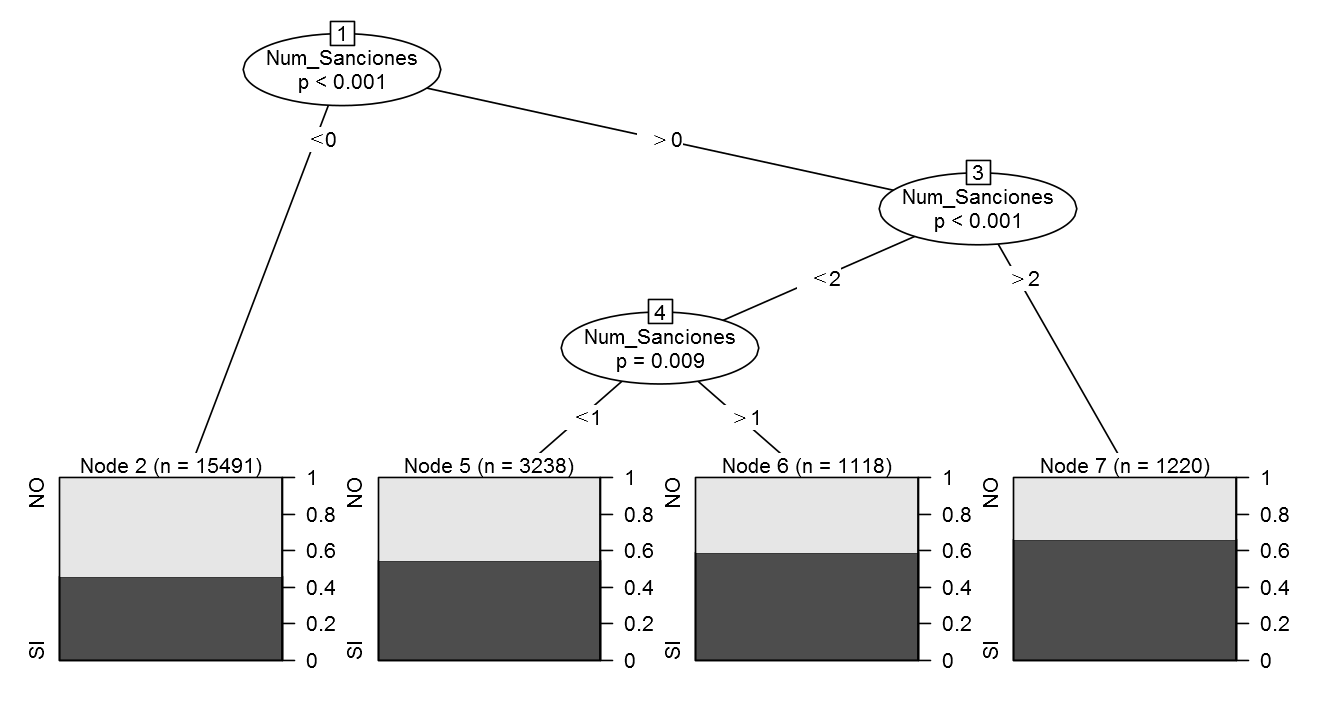

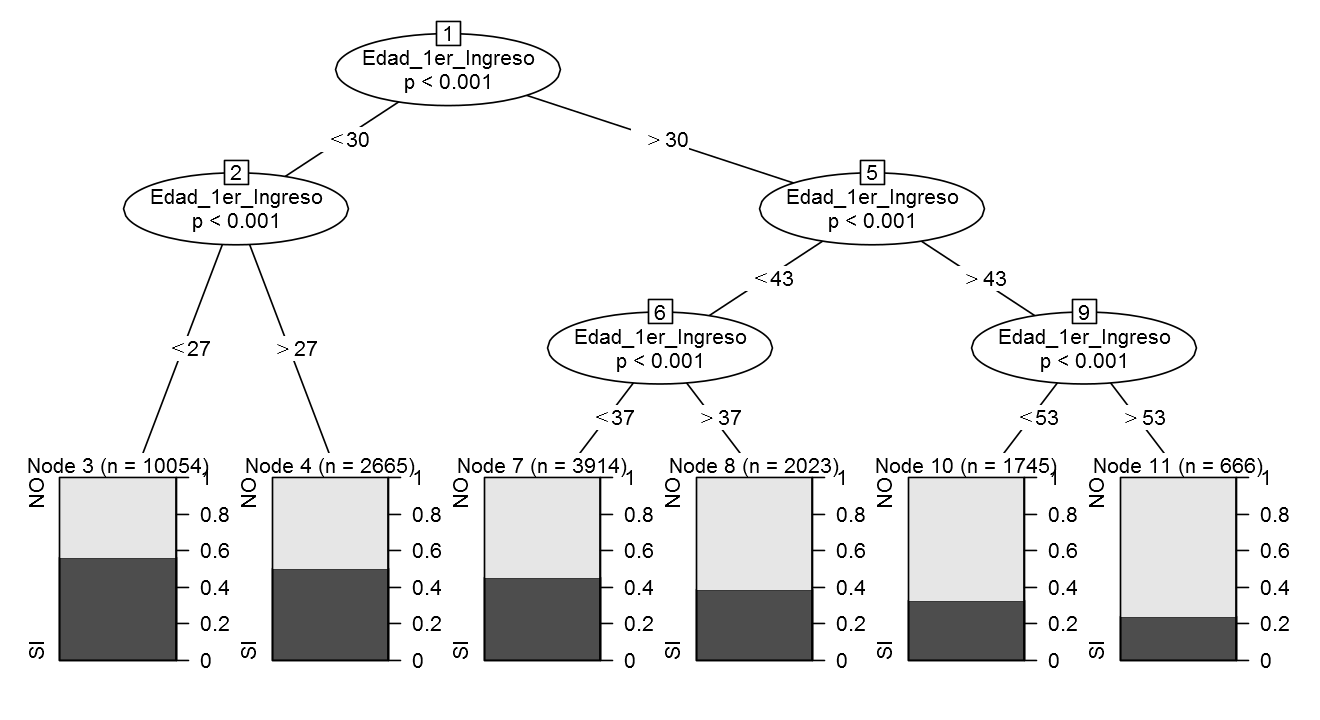

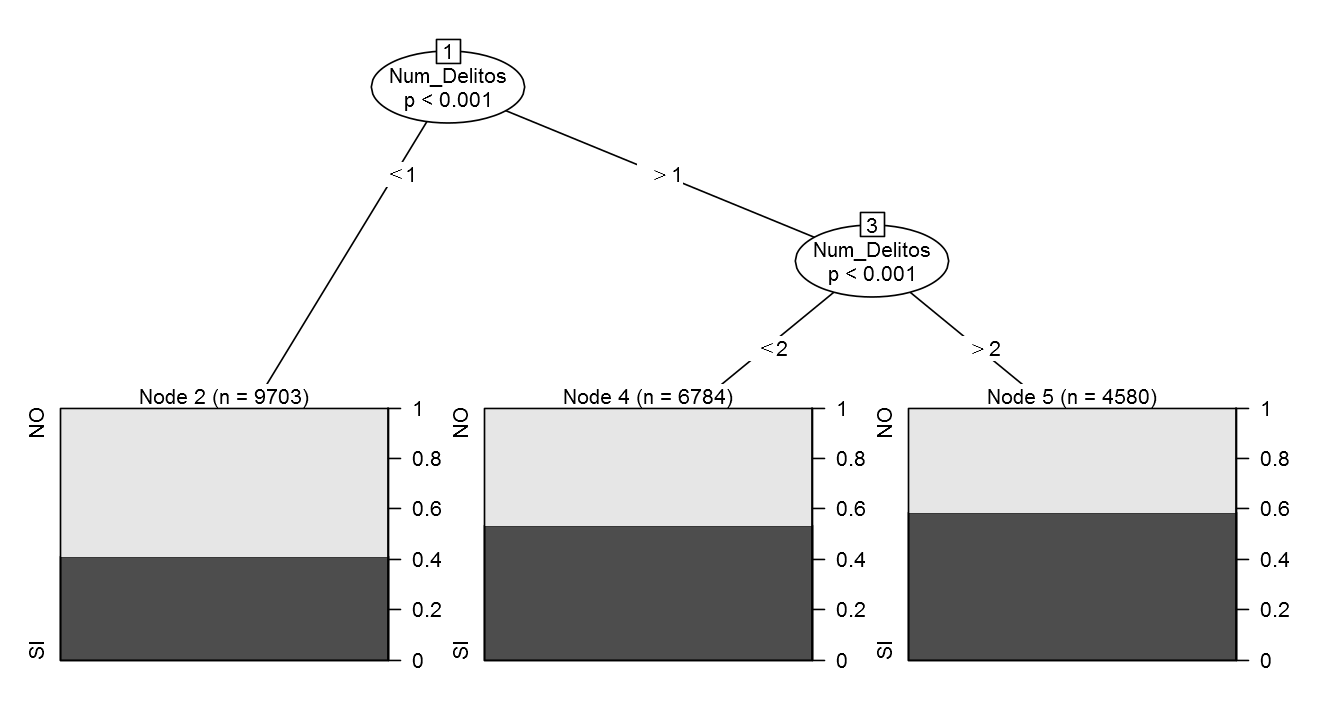

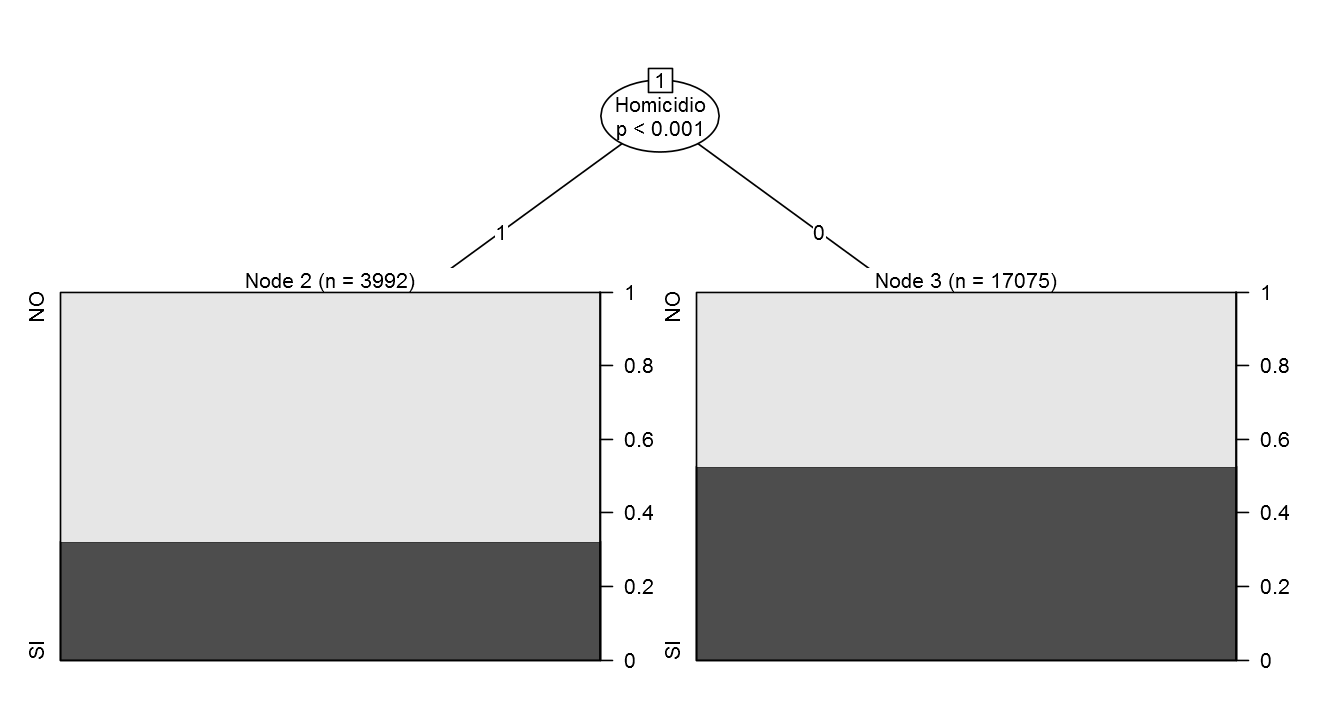

In [14]:
options(repr.plot.width=11, repr.plot.height=6) 
tree_dat=ctree(REINCIDENCIARECO ~ Calificacion, data=cuest_5)
# print(unique(cuestionario_3$Calificacion))
plot(tree_dat)
# table(cuestionario_3$REINCIDENCIARECO)

tree_dat=ctree(REINCIDENCIARECO ~ Num_Sanciones, data=cuest_5)
# print(unique(cuestionario_3$Num_Sanciones))
plot(tree_dat)
# table(cuestionario_3$REINCIDENCIARECO)

tree_dat=ctree(REINCIDENCIARECO ~ Edad_1er_Ingreso, data=cuest_5)
# print(unique(cuestionario_3$Edad_1er_Ingreso))
plot(tree_dat)
# table(cuestionario_3$REINCIDENCIARECO)

tree_dat=ctree(REINCIDENCIARECO ~ Num_Delitos, data=cuest_5)
# print(unique(cuestionario_3$Num_Delitos))
plot(tree_dat)
# table(cuestionario_3$REINCIDENCIARECO)

tree_dat=ctree(REINCIDENCIARECO ~ Homicidio, data=cuest_5)
# print(unique(cuestionario_3$Homicidio))
plot(tree_dat)
# table(cuestionario_3$REINCIDENCIARECO)